In [127]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads
import numpy as np
import torch
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy

Open up temperature data with NetCDF4 python library and print out the metadata. 

Full readme for file is available at: https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/Release_Notes_CRU_TS_4.08.txt

In [128]:
file_name = "/Users/alim/Documents/ccai_floods/cru_ts4.08.2011.2020.tmp.dat.nc"
file_id = Dataset(file_name)
print(file_id.variables)

{'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    long_name: time
    units: days since 1900-1-1
    calendar: gregorian
unlimited dimensions: time
current shape = (120,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'tmp': <class 'netCDF4._netCDF4.Variable'>
float32 tmp(time, lat, lon)
    long_name: near-surface temperature
    units: degrees Celsius
    correlation_decay_distance: 1200.0
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (120, 360, 720)
filling on, 'stn': <

Grab temperature and time data from netCDF4 file and display one timestamp:

(120, 360, 720)
(120,)


Text(0.5, 1.0, '40861')

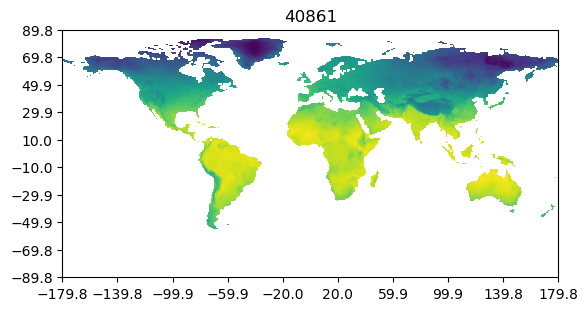

In [129]:
tmp = file_id.variables['tmp'][:]
print(tmp.shape)

flp_img = np.rot90(np.fliplr(tmp[10]), k=2)

time = file_id.variables['time'][:]
print(time.shape)

lon = file_id.variables['lon'][:]

lat = file_id.variables['lat'][:]

lon_plotting = np.linspace(lon[0], lon[-1], 10)
lat_plotting = np.linspace(lat[0], lat[-1], 10)
plt.xticks(lon_plotting)
plt.yticks(lat_plotting)
plt.imshow(flp_img, extent=[lon[0], lon[-1], lat[0], lat[-1]])
plt.title(str(int(time[10])))

Print out Lat and Long values:

In [130]:
print(len(list(lat)))

360


Get flood event ground truth data (https://floodobservatory.colorado.edu/temp/FloodArchive.txt)

In [131]:
print(os.getcwd())
gt = pd.read_csv('/Users/alim/Documents/ccai_floods/gt/FloodArchive.txt', encoding= 'unicode_escape', on_bad_lines='skip', 
                sep= '\t')

/Users/alim/Documents/ccai_floods/floods_in_kenya


Filter data for just Kenya:

In [132]:
print(gt.columns)

gt_kenya = gt[gt['Country'] == "Kenya"]
print(gt_kenya.shape)
gt_kenya = gt_kenya.reset_index(drop=True)

print(gt_kenya)

Index(['ID', 'GlideNumber', 'Country', 'OtherCountry', 'long', 'lat', 'Area',
       'Began', 'Ended', 'Validation', 'Dead', 'Displaced', 'MainCause',
       'Severity'],
      dtype='object')
(55, 14)
      ID         GlideNumber Country OtherCountry     long       lat  \
0   1064                   0   Kenya            0  34.6474 -0.478939   
1   1277                   0   Kenya            0  39.7108 -3.009670   
2   1284                   0   Kenya            0  39.8117 -0.852182   
3   1298                   0   Kenya      Somalia  36.7352 -2.306100   
4   1374                   0   Kenya            0  37.1670 -0.955933   
5   1915                   0   Kenya            0  36.9101 -1.218070   
6   2055                   0   Kenya            0  38.8525 -3.089840   
7   2078                   0   Kenya            0  40.0925 -1.415620   
8   2088                   0   Kenya            0  36.9154 -1.212670   
9   2108                   0   Kenya            0  35.9643  0.498246   
10  21

0    1996-04-08
1    1997-10-15
2    1997-11-30
3    1998-01-01
4    1998-05-27
5    2002-04-29
6    2002-09-16
7    2002-10-29
8    2002-11-17
9    2002-12-21
10   2003-01-04
11   2003-04-21
12   2003-08-26
13   2003-08-24
14   2004-04-09
15   2005-05-03
16   2005-06-17
17   2006-04-04
18   2006-10-15
19   2006-10-23
20   2007-04-21
21   2007-05-15
22   2007-11-21
23   2007-12-12
24   2008-03-20
25   2008-03-17
26   2008-03-28
27   2008-04-20
28   2008-06-13
29   2008-10-14
30   2008-11-10
31   2009-10-20
32   2009-12-21
33   2010-03-07
34   2010-05-08
35   2011-08-15
36   2011-11-09
37   2011-11-29
38   2012-04-09
39   2012-04-20
40   2012-08-15
41   2013-01-13
42   2013-03-28
43   2013-08-05
44   2015-04-05
45   2015-04-27
46   2015-12-01
47   2016-04-13
48   2017-05-08
49   2018-04-15
50   2019-10-05
51   2019-10-10
52   2020-03-27
53   2020-08-20
54   2021-04-23
Name: Began, dtype: datetime64[ns]


Text(0.5, 1.0, 'Distribution of Flood Events in Kenya over time - Starting')

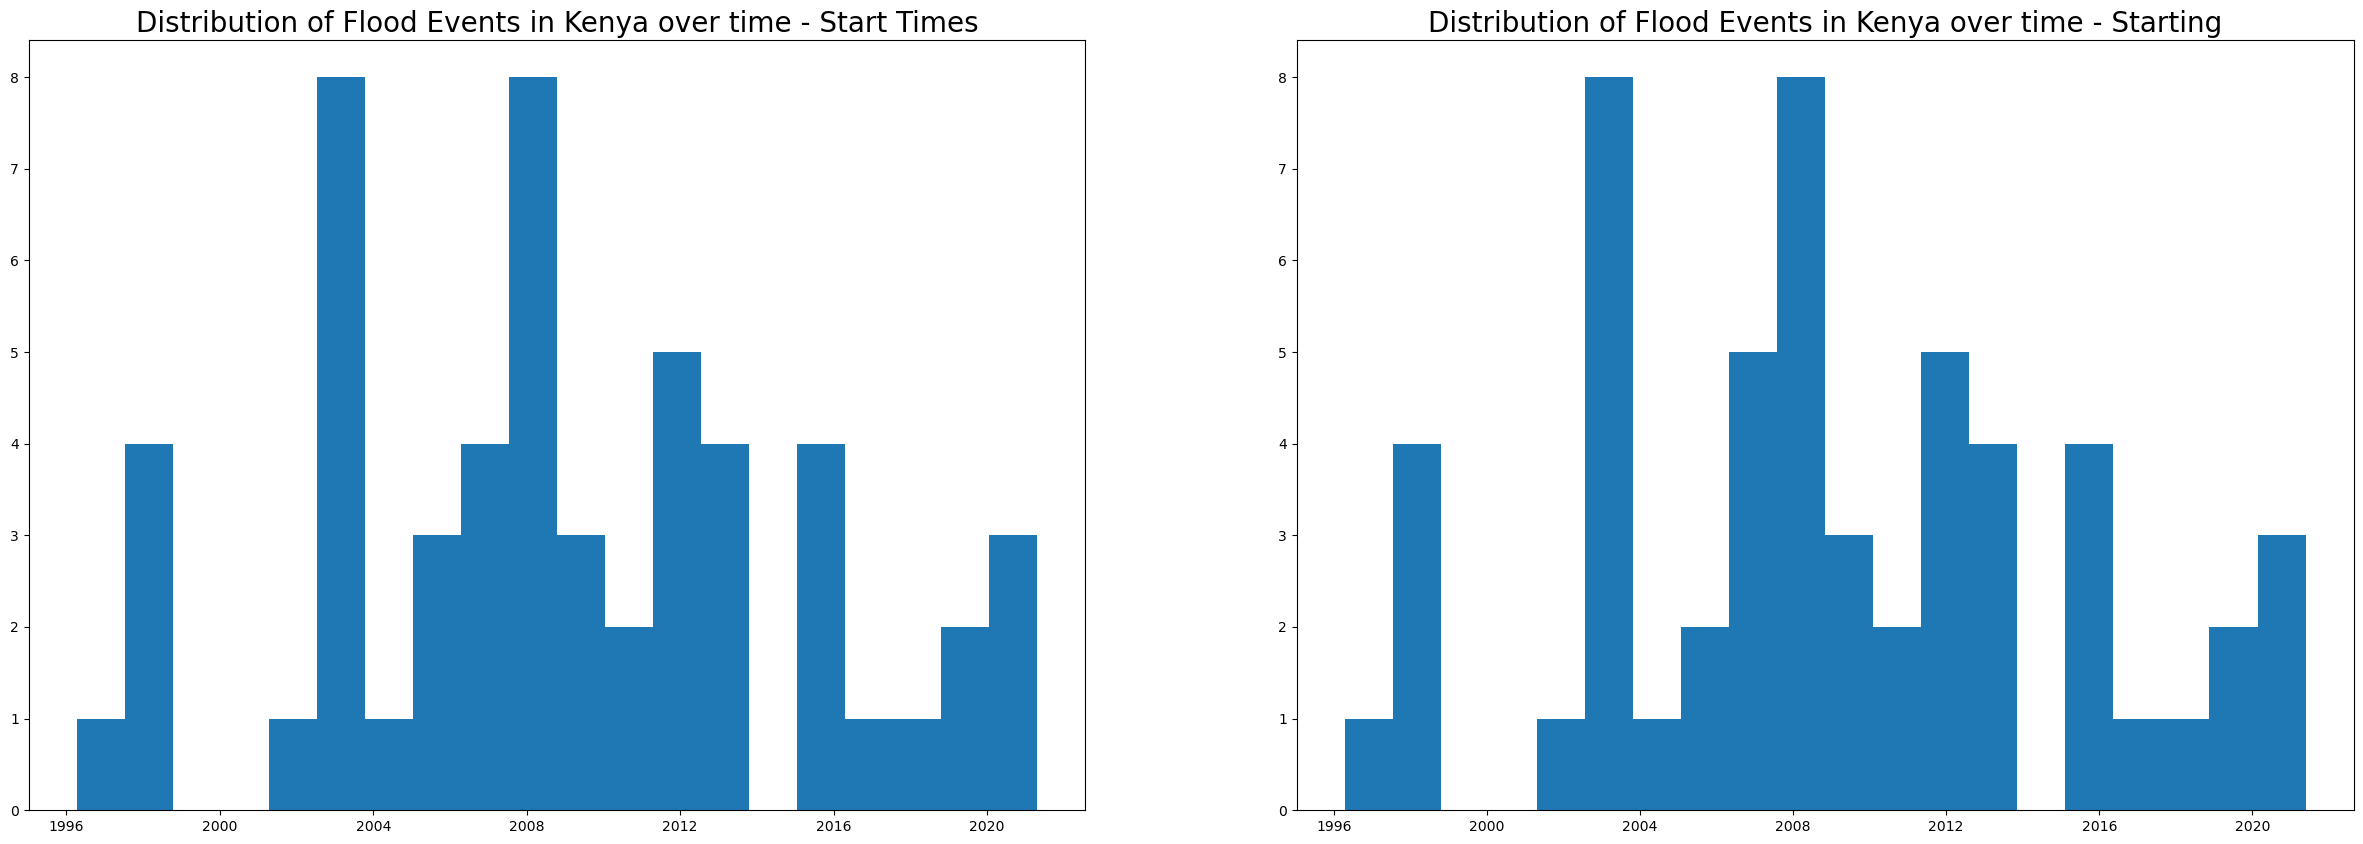

In [133]:
#update began and end date columns to date time format:
gt_kenya['Began'] = pd.to_datetime(gt_kenya['Began'], format='%Y%m%d')
gt_kenya['Ended'] = pd.to_datetime(gt_kenya['Ended'], format='%Y%m%d')



print(gt_kenya['Began'])

fig, ax = plt.subplots(1,2, figsize=(30,10))

ax[0].hist(gt_kenya['Began'], bins=20)
ax[1].hist(gt_kenya['Ended'], bins=20)

ax[0].set_title("Distribution of Flood Events in Kenya over time - Start Times", fontsize=20)
ax[1].set_title("Distribution of Flood Events in Kenya over time - Starting", fontsize=20)


Now, visualize spatially:

(1, 1) Index(['geometry'], dtype='object')
0    MULTIPOLYGON (((33.90983 0.09872, 33.91270 0.1...
Name: geometry, dtype: geometry


Text(0.5, 1.0, 'Flood Events in Kenya: 1996 - 2021')

<Figure size 2000x2000 with 0 Axes>

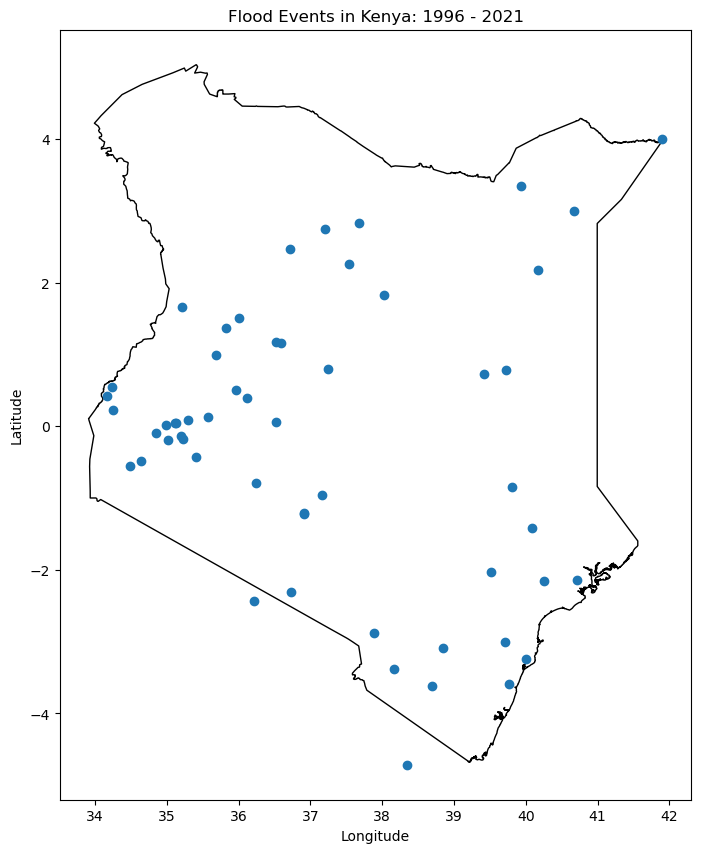

In [134]:
#load kenya shapefile:
shpfile_path = '/Users/alim/Documents/ccai_floods/kenya_shp/kenya_shp.shp' # need an shx file in the kenya_shp directory as well. 

kenya_shp = gpd.read_file(shpfile_path)
print(kenya_shp.shape, kenya_shp.columns)
print(kenya_shp['geometry'])

plt.figure(figsize=(20, 20))


kenya_shp.plot(facecolor="none", figsize=(10,10))


plt.scatter(x=gt_kenya['long'],y= gt_kenya['lat'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flood Events in Kenya: 1996 - 2021")

# for i, row in gt_kenya.iterrows():
#     plt.annotate(row['Began'].strftime('%Y-%m'), (row['long'], row['lat']), 
#                  textcoords="offset points", xytext=(0,10), ha='center')


Now that we have an events dataset, we need to sample them to a grid. Grid should be 0.25 by 0.25

In [135]:
import xarray as xr

nc_era5 = Dataset('download.nc')
print(nc_era5)

lon_era5 = nc_era5.variables['longitude'][:]

lat_era5 = nc_era5.variables['latitude'][:]

print(len(lon_era5))

print(len(lat_era5))

# generate a list of all the combinations of lat and long. 
# this can be done by taking the cartesian product of the list of longs and list of lats. (A x B , where x is the cartesian product, will
# generate the set of all ordered pairs (a,b) where a is in set A and b is in set B).

import itertools

cartesian_product_lon_lat = np.array(list(itertools.product(lat_era5, lon_era5)))

print(type(cartesian_product_lon_lat))
print(cartesian_product_lon_lat)
print(len(lat_era5) * len(lon_era5))
print(len(cartesian_product_lon_lat))


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-08-18 17:25:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data1/adaptor.mars.internal-1724001907.6254005-2421-4-b987bfb6-a606-46d1-9636-05b0c0702a3e.nc /cache/tmp/b987bfb6-a606-46d1-9636-05b0c0702a3e-adaptor.mars.internal-1724000197.5845363-2421-3-tmp.grib
    dimensions(sizes): longitude(35), latitude(41), time(2928)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 dl(time, latitude, longitude), int16 lai_hv(time, latitude, longitude), int16 lai_lv(time, latitude, longitude), int16 slt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 
35
41
<class 'numpy.ndarray'>
[[ 5.   34.  ]
 [ 5.   34.25]
 [ 5.   34.5 ]
 ...
 [-5.   42.  ]
 [-5.   42.25]
 [-5.   42.5 ]]
1435
1435


In [136]:
def find_closest_vector(source, target):
    # Calculate the Euclidean distance between each row in the source matrix and the target vector
    distances = np.linalg.norm(source - target, axis=1)
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    # Return the closest vector and its index
    return source[min_index], min_index

# Example usage
source = cartesian_product_lon_lat  # 20x2 matrix with random values
target = np.array([0, 40.4])   # 1x2 target vector

closest_vector, index = find_closest_vector(source=cartesian_product_lon_lat, target=target)
print(f"Closest vector: {closest_vector}")
print(f"Index of closest vector: {index}")



Closest vector: [ 0.  40.5]
Index of closest vector: 726


In [137]:
def convert_coordinates_to_2d_index(coordinates, range_lon, range_lat, verbose=False):
    """
    Given a range of latitudes and longitudes with a given spacing, this function takes coordinates in the (long, lat) (note 
    that long, lat is the same as row, col order) and returns a 2d index (0 based indexing) so that downstream code can plot 
    something based on this indexing system. 
    """
    idx_col = np.argmin(np.abs(range_lon - coordinates[1]))

    idx_row = np.argmin(np.abs(range_lat - coordinates[0]))
    if verbose:
        print(idx_row, idx_col)
        print(range_lon, range_lat)

    return (idx_row, idx_col)

convert_coordinates_to_2d_index(coordinates = np.array([5, 42]), range_lon = lon_era5, range_lat = lat_era5)

(0, 32)

In [138]:
# create an empty array which is the size of the spatial dimension of the data in ERA5.
target_cube = np.zeros((len(lat_era5), len(lon_era5)))
print(target_cube.shape)

# for each flood event in the gt_kenya, find the lat / long in the ERA5 grid system that is closest. 
# then, convert that lat / long in the ERA5 grid system to a 2d index (row, col).
# add 1 to the np_empty array - this will signify a GT event in that cell.

def append_flood_observation(target_cube, ground_truth_df):
    # get event longs, lats from ground_truth_df:
    temp_lon, temp_lat = ground_truth_df['long'], ground_truth_df['lat']
    #print(temp_lon, temp_lat)

    # for each long, lat, use the find_closest_vector_2d function to find the closest long/lat in the ERA5 grid system
    for obs_coordinates in zip(temp_lat, temp_lon):
        # use find_closest_vector_2d function
        closest_vector, index = find_closest_vector(cartesian_product_lon_lat, obs_coordinates)
        print(f"Closest vector:{closest_vector}")
        print(f"Index of closest vector: {index}")
        # convert that closest vector to a 2d zero based indexing system. 
        temp_raster_idx = convert_coordinates_to_2d_index(closest_vector, range_lon = lon_era5, range_lat = lat_era5)
        temp_row_idx, temp_col_idx = temp_raster_idx[0], temp_raster_idx[1]
        # add 1 to the target_cube
        target_cube[temp_row_idx, temp_col_idx]+= 1

    return target_cube
target_cube = append_flood_observation(target_cube, ground_truth_df=gt_kenya)

(41, 35)
Closest vector:[-0.5  34.75]
Index of closest vector: 773
Closest vector:[-3.   39.75]
Index of closest vector: 1143
Closest vector:[-0.75 39.75]
Index of closest vector: 828
Closest vector:[-2.25 36.75]
Index of closest vector: 1026
Closest vector:[-1.   37.25]
Index of closest vector: 853
Closest vector:[-1.25 37.  ]
Index of closest vector: 887
Closest vector:[-3.   38.75]
Index of closest vector: 1139
Closest vector:[-1.5 40. ]
Index of closest vector: 934
Closest vector:[-1.25 37.  ]
Index of closest vector: 887
Closest vector:[ 0.5 36. ]
Index of closest vector: 638
Closest vector:[ 0.   34.75]
Index of closest vector: 703
Closest vector:[-0.25 35.25]
Index of closest vector: 740
Closest vector:[ 0.25 34.25]
Index of closest vector: 666
Closest vector:[ 1.   35.75]
Index of closest vector: 567
Closest vector:[ 0.   35.25]
Index of closest vector: 705
Closest vector:[ 0.75 37.25]
Index of closest vector: 608
Closest vector:[ 0.5  34.25]
Index of closest vector: 631
Closes

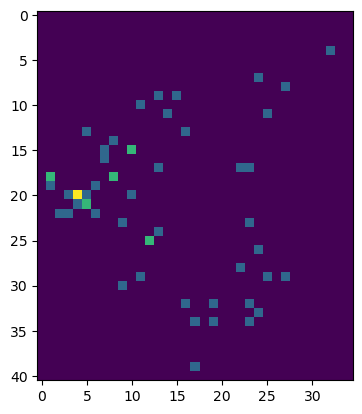

In [139]:
plt.imshow(target_cube)

In [ ]:
# now, build spatial_temporal cube.
